[제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec4/Lab6_result_report.ipynb)를 통해 Colab에서 바로 작업하실 수 있습니다!  
런타임 유형은 python3, GPU 가속 확인하기!

In [1]:
!mkdir results

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

## Data Preparation

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model Architecture

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Train, Validate, Test and Experiment

In [5]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [6]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [7]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [8]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result
    # ===================================== #

# Manage Experiment Result

In [9]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

## Experiment

In [10]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)    #args.name_var1 = var1
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)


Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 23.74/22.55, Loss(train/val) 24.50/30.90. Took 10.02 sec
Epoch 1, Acc(train/val): 26.25/26.77, Loss(train/val) 25.04/26.04. Took 10.05 sec
Epoch 2, Acc(train/val): 26.97/25.62, Loss(train/val) 18.93/26.72. Took 10.00 sec
Epoch 3, Acc(train/val): 27.18/27.47, Loss(train/val) 19.70/19.76. Took 9.96 sec
Epoch 4, Acc(train/val): 27.49/23.95, Loss(train/val) 18.36/28.73. Took 10.01 sec
Epoch 5, Acc(train/val): 27.33/25.92, Loss(train/val) 20.52/25.51. Took 9.93 sec
Epoch 6, Acc(train/val): 27.84/27.35, Loss(train/val) 16.44/26.33. Took 9.99 sec
Epoch 7, Acc(train/val): 27.09/27.31, Loss(train/val) 18.08/20.90. Took 9.88 sec
Epoch 8, Acc(train/val): 28.47/26.53, Loss(train/val) 16.98/25.00. Took 9.84 sec
Epoch 9, Acc(train/val): 28.



---




In [11]:
!ls results

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json


In [12]:
!cat results/exp1_n_layer_hid_dim-41b634.json 

{"train_losses": [2.203987249902859, 1.92869421479049, 1.8205574568669507, 1.7263124588948147, 1.6694068567008729, 1.6204853088233122, 1.5684664530359256, 1.5234961350252674, 1.4665326123025006, 1.4232033825224373], "val_losses": [1.9051910519599915, 1.8153194069862366, 1.7398542046546936, 1.648781454563141, 1.6167163014411927, 1.5848856568336487, 1.5491471648216248, 1.50069580078125, 1.4726057648658752, 1.4736953973770142], "train_accs": [25.145, 30.7325, 33.64, 37.4375, 39.57, 41.605, 43.765, 45.32, 47.4275, 48.7825], "val_accs": [31.12, 34.96, 36.84, 40.88, 42.08, 41.88, 44.16, 46.01, 47.22, 47.29], "train_acc": 48.7825, "val_acc": 47.29, "test_acc": 46.95, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true, "l2": 1e-05, "use_xavier": true, "optim": "RMSprop", "lr": 0.0015, "train_batch_size": 256, "n_layer": 3}

In [13]:
load_exp_result('exp1')

,train_losses,val_losses,train_accs,val_accs,train_acc,val_acc,test_acc,exp_name,in_dim,out_dim,hid_dim,act,dropout,use_bn,l2,use_xavier,optim,lr,train_batch_size,n_layer
0,"[2.5484492080226824, 2.1015224251777505, 1.872...","[2.4757749319076536, 1.9120594382286071, 1.767...","[22.805, 28.6275, 32.5, 36.62, 38.3575, 40.687...","[28.9, 30.27, 35.86, 38.41, 37.91, 43.37, 44.4...",49.2650,47.79,47.34,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3
1,"[2.3029047220375887, 1.9913959366500757, 1.829...","[1.975100612640381, 1.8911096930503846, 1.8110...","[25.8125, 30.8475, 33.6825, 37.12, 39.85, 42.4...","[31.64, 34.37, 35.26, 40.54, 42.24, 43.02, 44....",51.4675,48.91,48.69,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
2,"[16.552919012725734, 14.949176876408279, 11.61...","[20.114421081542968, 15.635308837890625, 15.27...","[22.9075, 24.6975, 25.15, 25.08, 25.865, 26.63...","[24.53, 25.15, 23.31, 23.4, 25.85, 23.27, 26.6...",26.8075,22.25,22.34,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
3,"[2.1241643914751185, 1.8965361627044193, 1.783...","[1.9913589596748351, 2.1339974284172056, 2.185...","[26.8275, 31.9775, 35.475, 37.8325, 40.2925, 4...","[33.61, 35.23, 39.36, 39.38, 41.03, 44.63, 46....",50.3475,47.54,47.21,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,2
4,"[24.49879532558903, 25.044733320831494, 18.929...","[30.89795513153076, 26.044148254394532, 26.723...","[23.7425, 26.25, 26.9725, 27.175, 27.49, 27.33...","[22.55, 26.77, 25.62, 27.47, 23.95, 25.92, 27....",28.3675,25.59,26.19,exp1_n_layer_hid_dim,3072,10,500,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,1
5,"[2.203987249902859, 1.92869421479049, 1.820557...","[1.9051910519599915, 1.8153194069862366, 1.739...","[25.145, 30.7325, 33.64, 37.4375, 39.57, 41.60...","[31.12, 34.96, 36.84, 40.88, 42.08, 41.88, 44....",48.7825,47.29,46.95,exp1_n_layer_hid_dim,3072,10,300,relu,0.2,True,0.00001,True,RMSprop,0.0015,256,3


In [14]:
print(type(load_exp_result('exp1')))

<class 'pandas.core.frame.DataFrame'>


In [15]:
# DataFrame

a = [{'age':5, 'gender':'f', 'score':10, 't':1},{'age':6, 'gender':'m', 'score':9, 't':1}, 
     {'age':10, 'gender':'f', 'score':15, 't':1}, {'age':8, 'gender':'m','score':33, 't':2},
     {'age':3, 'gender':'f', 'score':2, 't':2}, {'age':3, 'gender':'m', 'score':10, 't':2}]

df = pd.DataFrame(a)
df

,age,gender,score,t
0,5,f,10,1
1,6,m,9,1
2,10,f,15,1
3,8,m,33,2
4,3,f,2,2
5,3,m,10,2


0.11.0


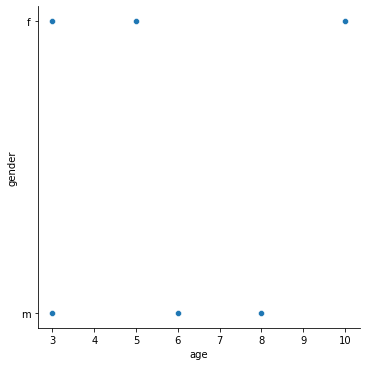

In [16]:
import seaborn as sns 
import matplotlib.pyplot as plt

print(sns.__version__)
sns.relplot(x='age', y='gender', data=df)

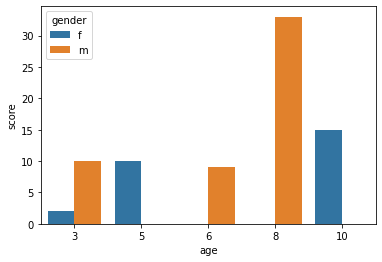

In [17]:
sns.barplot(x='age', y='score', hue='gender', data=df)

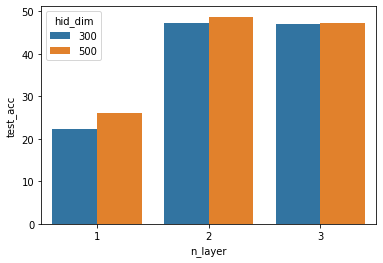

In [18]:
result = load_exp_result('exp1')

sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=result)

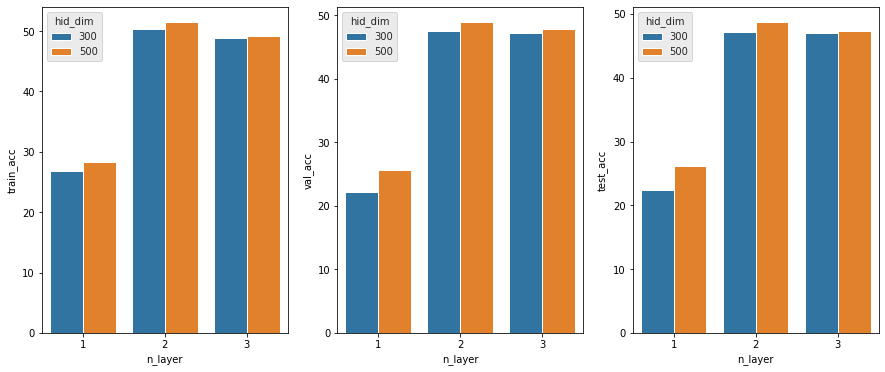

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

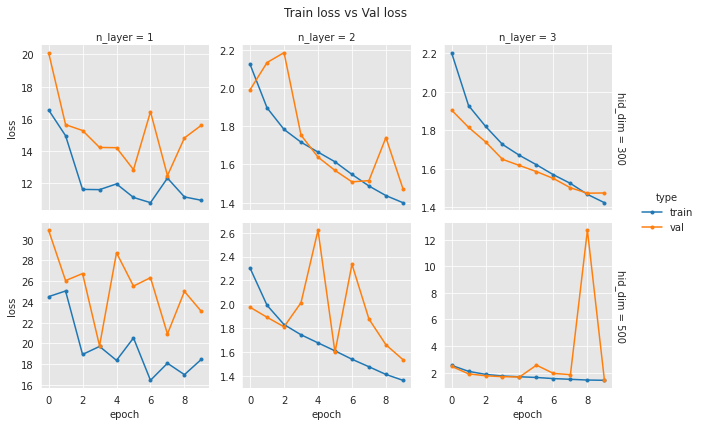

In [20]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.') #subplot = plt.plot / x=epoch/ y=loss
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

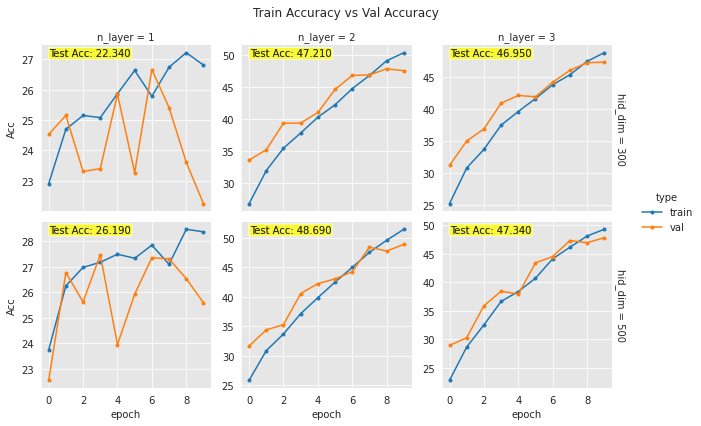

In [21]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [22]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_dropout"

# ====== Model Capacity ====== #
args.n_layer = 3
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 300
args.act = 'relu'

# ====== Regularization ======= #
#args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
#args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.00005, 0.001, 0.005]
list_var2 = [0, 0.1, 0.2, 0.3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)    #args.name_var1 = var1
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)


Namespace(act='relu', dropout=0, epoch=10, exp_name='exp2_lr_dropout', hid_dim=300, in_dim=3072, l2=1e-05, lr=5e-05, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 39.65/45.53, Loss(train/val) 1.70/1.56. Took 9.76 sec
Epoch 1, Acc(train/val): 46.27/46.78, Loss(train/val) 1.51/1.49. Took 9.83 sec
Epoch 2, Acc(train/val): 49.99/49.18, Loss(train/val) 1.41/1.45. Took 9.99 sec
Epoch 3, Acc(train/val): 52.88/50.16, Loss(train/val) 1.34/1.42. Took 10.06 sec
Epoch 4, Acc(train/val): 55.52/50.21, Loss(train/val) 1.26/1.41. Took 9.90 sec
Epoch 5, Acc(train/val): 58.01/50.86, Loss(train/val) 1.19/1.40. Took 9.92 sec
Epoch 6, Acc(train/val): 60.74/50.81, Loss(train/val) 1.11/1.42. Took 9.86 sec
Epoch 7, Acc(train/val): 62.76/50.66, Loss(train/val) 1.06/1.44. Took 9.76 sec
Epoch 8, Acc(train/val): 64.91/51.83, Loss(train/val) 0.99/1.43. Took 9.77 sec
Epoch 9, Acc(train/val): 67.06/52.36, Loss(train/val) 0.9

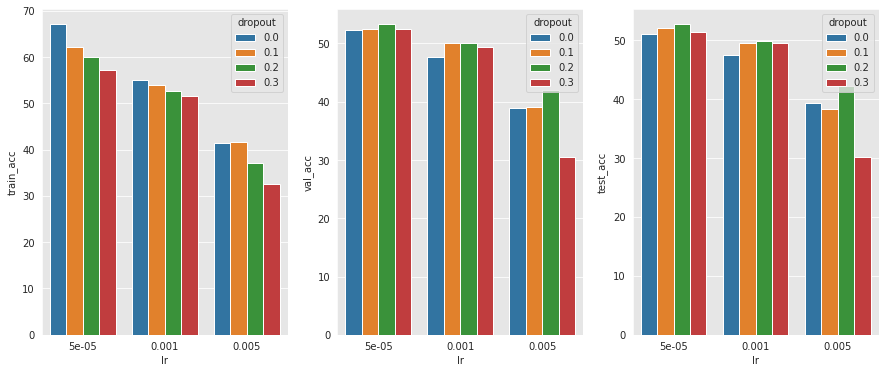

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

df = load_exp_result('exp2')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='lr', y='train_acc', hue='dropout', data=df, ax=ax[0])
sns.barplot(x='lr', y='val_acc', hue='dropout', data=df, ax=ax[1])
sns.barplot(x='lr', y='test_acc', hue='dropout', data=df, ax=ax[2])

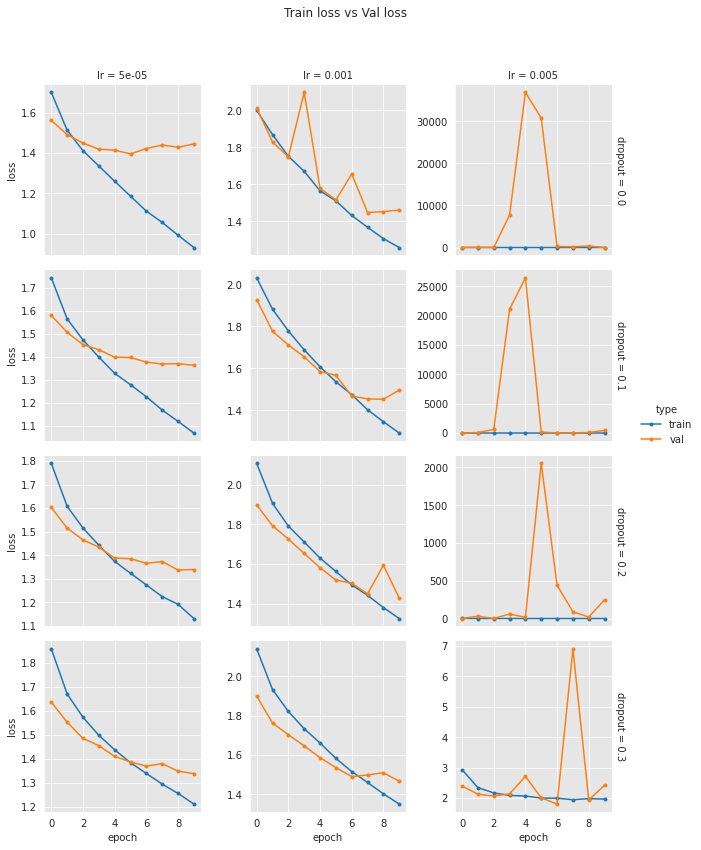

In [27]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp2')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.') #subplot = plt.plot / x=epoch/ y=loss
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

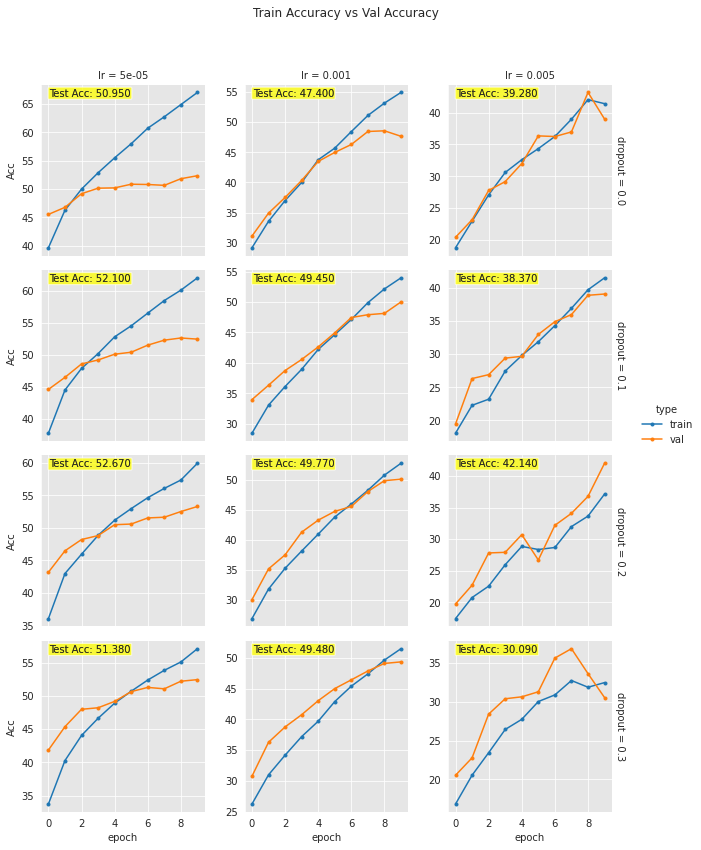

In [28]:
var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp2')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)